In [1]:
import numpy as np
import scipy.io as sio
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.contrib.layers import xavier_initializer


import matplotlib.pyplot as plt
%matplotlib inline

data_file = 'data/preprocessed.mat'

EPS = 1e-8
random_seed = 1234

In [2]:
data = sio.loadmat(data_file)

In [3]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'images', 'bags', 'labels', 'n_instance', 'instance_dim'])

In [4]:
X = data['bags']
Y = data['labels']
Y[Y == -1] = -1 #convert to 1,-1 labelling

In [5]:
n_instance = data['n_instance']
instance_dim = np.prod(data['instance_dim'])
n_classes = Y.shape[1]

# Train, validate, test split

In [6]:
test_prop = 1/3
validate_prop = 1/6

random_state = 42

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,                            
    test_size=test_prop,                             
    random_state=random_state
)

X_train, X_validate, Y_train, Y_validate = train_test_split(
    X_train, Y_train,                   
    test_size=validate_prop/(1-test_prop), 
    random_state=random_state
)

In [7]:
print(Y_train.shape)
print(Y_validate.shape)
print(Y_test.shape)

(999, 5)
(334, 5)
(667, 5)


In [8]:
X_train.shape

(999, 20, 1200)

# Simple linear model

Linear model:
$$h_{ijk} = <\vec{x_{ij}}, \vec{w_k}> + b_k$$ 

Each instance can be at most one class:
$$p_{ijk} = \frac{e^{h_{ijk}}}{\sum_{k' = 1}^K e^{h_{ijk'}}}$$

Probability that at least one instance in bag $i$ is of class k:
$$p_{i \bullet k} = P(y_{i \bullet k} = 1) = P(\exists j \in \{1,\ldots,J\}; y_{ijk} = 1) = 1 - \prod_{j = 1}^J (1-p_{ijk})$$

Approximation to SVM: 
$$h_{i \bullet k} = \text{logit}(p_{i \bullet k})$$

$$\mathcal{L}_k = \frac{1}{2}||\vec{w_k}|| + \lambda \sum_{i}  max\left(0, \ 1-y_{i \bullet k}h_{i \bullet k}\right)  $$

$$\mathcal{L} = \sum_k \mathcal{L}_k$$

In [16]:
class MCMIL(object):
    def __init__(self, instance_dim, n_classes):
        self.instance_dim = instance_dim
        self.n_classes = n_classes
        
        #Weights
        xavier_init = xavier_initializer(seed = random_seed)
        W = tf.Variable(xavier_init(
            [
                instance_dim,
                n_classes
            ]
        ), name = 'W')
        self.W = W
        
        b = tf.Variable(np.zeros(
            [
                n_classes
            ]
        ).astype('float32'), name = 'b')
        self.b = b
        
        self.params = [W, b]
        
        #Placeholders
        X = tf.placeholder(tf.float32, shape = [None, None, instance_dim])
        self.X = X
        Y = tf.placeholder(tf.float32, shape = [None, n_classes])
        self.Y = Y
        lamb = tf.placeholder(tf.float32, shape = 1)
        self.lamb = lamb
        
        #Loss
        h_ijk = tf.einsum('ijl,lk->ijk', X, W) + b
        self.h_ijk = h_ijk
        p_ijk = tf.nn.softmax(h_ijk, 2)
        self.p_ijk = p_ijk
        p_i_k = 1 - tf.reduce_prod(1-p_ijk, 1)
        self.p_i_k = p_i_k
        h_i_k = tf.log(p_i_k / (1 - p_i_k + EPS) + EPS)
        self.h_i_k = h_i_k
        L = .5*tf.reduce_mean(tf.einsum('ij,ij->j', W, W)) + lamb * tf.reduce_mean(tf.maximum(0.0, 1 - Y*h_i_k))
        self.Loss = L
        
    def train(self, x, y, lamb = 1, epochs = 100, mb_size = 50, lr = .01, print_every = 100,):
        #Optimizer 
        solver = tf.train.AdagradOptimizer(learning_rate = lr).minimize(self.Loss, var_list=self.params)
        
        #Training
        init = tf.global_variables_initializer()
        sess = tf.Session()
        self.sess = sess
        with sess.as_default():
            sess.run(init)
            n_batches = int(len(y)/float(mb_size))
            losses = []
            for epoch in range(epochs):
                if epoch % print_every == 0:
                    print(epoch)
                idxs = np.arange(len(y))
                np.random.shuffle(idxs)
                epochloss = 0
                for batch in range(n_batches):
                    mb_idxs = idxs[batch*mb_size:(1+batch)*mb_size]
                    x_mb = x[mb_idxs]
                    y_mb = y[mb_idxs]
                    _, loss = sess.run([solver, self.Loss], feed_dict = {self.X:x_mb, self.Y:y_mb, self.lamb: [lamb]})
                    epochloss += loss/n_batches
                losses.append(epochloss)
            plt.plot(losses)
    
    def predict_instance_proba(self, x):
        return(self.sess.run([self.p_ijk], feed_dict = {self.X:x}))
    
    def predict_bag_proba(self, x):
        return(self.sess.run([self.p_i_k], feed_dict = {self.X:x}))

In [22]:
def proba_to_label(p):
    return((p > .5).astype(int)*2 - 1)

In [31]:
mcmil = MCMIL(X.shape[-1], Y.shape[-1])

0
100
200
300
400
500
600
700
800
900


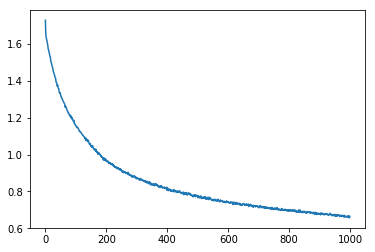

In [32]:
mcmil.train(X_train, Y_train, lamb = .1, epochs = 1000, mb_size = 100, lr = .001, print_every = 100)

In [33]:
p_train = mcmil.predict_bag_proba(X_train)[0]
Y_hat_train = proba_to_label(p_train)
acc_train = np.mean(Y_hat_train == Y_train)
print("Training accuracy: %.3f" %acc_train)

Training accuracy: 0.642


In [34]:
p_validate = mcmil.predict_bag_proba(X_validate)[0]
Y_hat_validate = proba_to_label(p_validate)
acc_validate = np.mean(Y_hat_validate == Y_validate)
print("Validation accuracy: %.3f" %acc_validate)

Validation accuracy: 0.556


0
100
200
300
400
500
600
700
800
900


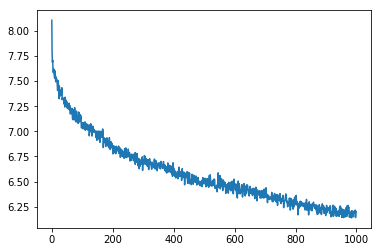

In [35]:
mcmil.train(X_train, Y_train, lamb = 1, epochs = 1000, mb_size = 100, lr = .001, print_every = 100)

In [36]:
p_train = mcmil.predict_bag_proba(X_train)[0]
Y_hat_train = proba_to_label(p_train)
acc_train = np.mean(Y_hat_train == Y_train)
print("Training accuracy: %.3f" %acc_train)

Training accuracy: 0.679


In [37]:
p_validate = mcmil.predict_bag_proba(X_validate)[0]
Y_hat_validate = proba_to_label(p_validate)
acc_validate = np.mean(Y_hat_validate == Y_validate)
print("Validation accuracy: %.3f" %acc_validate)

Validation accuracy: 0.595


0
100
200
300
400
500
600
700
800
900


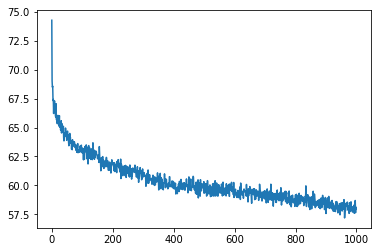

In [38]:
mcmil.train(X_train, Y_train, lamb = 10, epochs = 1000, mb_size = 100, lr = .001, print_every = 100)

In [39]:
p_train = mcmil.predict_bag_proba(X_train)[0]
Y_hat_train = proba_to_label(p_train)
acc_train = np.mean(Y_hat_train == Y_train)
print("Training accuracy: %.3f" %acc_train)

Training accuracy: 0.678


In [40]:
p_validate = mcmil.predict_bag_proba(X_validate)[0]
Y_hat_validate = proba_to_label(p_validate)
acc_validate = np.mean(Y_hat_validate == Y_validate)
print("Validation accuracy: %.3f" %acc_validate)

Validation accuracy: 0.605


0
100
200
300
400
500
600
700
800
900


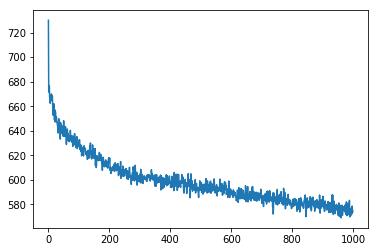

In [41]:
mcmil.train(X_train, Y_train, lamb = 100, epochs = 1000, mb_size = 100, lr = .001, print_every = 100)

In [42]:
p_train = mcmil.predict_bag_proba(X_train)[0]
Y_hat_train = proba_to_label(p_train)
acc_train = np.mean(Y_hat_train == Y_train)
print("Training accuracy: %.3f" %acc_train)

Training accuracy: 0.677


In [43]:
p_validate = mcmil.predict_bag_proba(X_validate)[0]
Y_hat_validate = proba_to_label(p_validate)
acc_validate = np.mean(Y_hat_validate == Y_validate)
print("Validation accuracy: %.3f" %acc_validate)

Validation accuracy: 0.607
